## Import Library and Mount Google Drive

In [1]:
from keras import *
import tensorflow as tf
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
plt.style.use('dark_background')
from keras.layers import Activation, LeakyReLU, Dropout
from tensorflow.keras.activations import sigmoid
from keras.utils.generic_utils import get_custom_objects
from keras import backend as K
from sklearn.preprocessing import StandardScaler
import os 
import statistics

In [2]:
# seed for reproducible results
seed_value= 2020
os.environ['PYTHONHASHSEED']=str(seed_value)
np.random.seed(seed_value)
tf.random.set_seed(seed_value)

In [3]:
# commands for google colab
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
os.chdir('/content/drive/My Drive/AML')
train_folder = "Train_Assignment_1/"

Mounted at /content/drive


In [4]:
!python setup.py install

running install
running bdist_egg
running egg_info
writing keras_lr_finder.egg-info/PKG-INFO
writing dependency_links to keras_lr_finder.egg-info/dependency_links.txt
writing requirements to keras_lr_finder.egg-info/requires.txt
writing top-level names to keras_lr_finder.egg-info/top_level.txt
reading manifest file 'keras_lr_finder.egg-info/SOURCES.txt'
writing manifest file 'keras_lr_finder.egg-info/SOURCES.txt'
installing library code to build/bdist.linux-x86_64/egg
running install_lib
running build_py
creating build/bdist.linux-x86_64/egg
creating build/bdist.linux-x86_64/egg/keras_lr_finder
copying build/lib/keras_lr_finder/__init__.py -> build/bdist.linux-x86_64/egg/keras_lr_finder
copying build/lib/keras_lr_finder/lr_finder.py -> build/bdist.linux-x86_64/egg/keras_lr_finder
byte-compiling build/bdist.linux-x86_64/egg/keras_lr_finder/__init__.py to __init__.cpython-36.pyc
byte-compiling build/bdist.linux-x86_64/egg/keras_lr_finder/lr_finder.py to lr_finder.cpython-36.pyc
creating 

## Preprocessing

### read CSV dataset

In [5]:
train = pd.read_csv(train_folder+"X_train.csv")
train_label = pd.read_csv(train_folder+"y_train.csv")
test = pd.read_csv(train_folder+"X_test.csv")

In [6]:
train

,Unnamed: 0,latitude,longitude,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365,Private_room,Entire_home/apt
0,0,40.71239,-73.95271,4,2,0.19,1,0,1,0
1,1,40696.00000,-73.91303,4,17,0.66,2,307,1,0
2,2,40.62707,-74.02817,3,1,0.04,1,87,0,0
3,3,40.77910,-73.98565,1,4,0.08,1,0,0,1
4,4,40.75777,-73.93509,1,0,0.00,1,358,1,0
...,...,...,...,...,...,...,...,...,...,...
33879,33879,40.71187,-73.95864,1,0,0.00,2,0,1,0
33880,33880,40.74123,-73.90152,30,0,0.00,103,247,1,0
33881,33881,40.73375,-73.95570,2,3,0.23,1,0,1,0
33882,33882,40.73660,-73.92358,30,1,0.19,103,252,1,0


In [7]:
train_label

,Unnamed: 0,price
0,0,65
1,1,57
2,2,225
3,3,175
4,4,125
...,...,...
33879,33879,150
33880,33880,59
33881,33881,60
33882,33882,39


### Data Cleaning

remove columns not useful

In [8]:
train2 = pd.merge(train, train_label,  how='inner', on=['Unnamed: 0'])
train2.drop(['Unnamed: 0'], axis=1, inplace=True)
train2.describe()

,latitude,longitude,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365,Private_room,Entire_home/apt,price
count,33884.000000,33884.000000,33884.000000,33884.000000,33884.000000,33884.000000,33884.000000,33884.000000,33884.000000,33884.000000
mean,393.742123,-767.324528,7.109904,23.391778,1.095455,7.101080,112.995839,0.456085,0.520127,153.605389
std,3773.366411,7123.758128,20.234836,44.608022,1.610452,32.746915,131.641035,0.498075,0.499602,249.102710
min,40.499790,-74142.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,40.690427,-73.983503,1.000000,1.000000,0.040000,1.000000,0.000000,0.000000,0.000000,69.000000
50%,40.723645,-73.956025,3.000000,5.000000,0.370000,1.000000,45.000000,0.000000,1.000000,106.000000
75%,40.763910,-73.937005,5.000000,24.000000,1.590000,2.000000,227.000000,1.000000,1.000000,175.000000
max,40894.000000,-73.712990,1000.000000,629.000000,58.500000,327.000000,365.000000,1.000000,1.000000,10000.000000


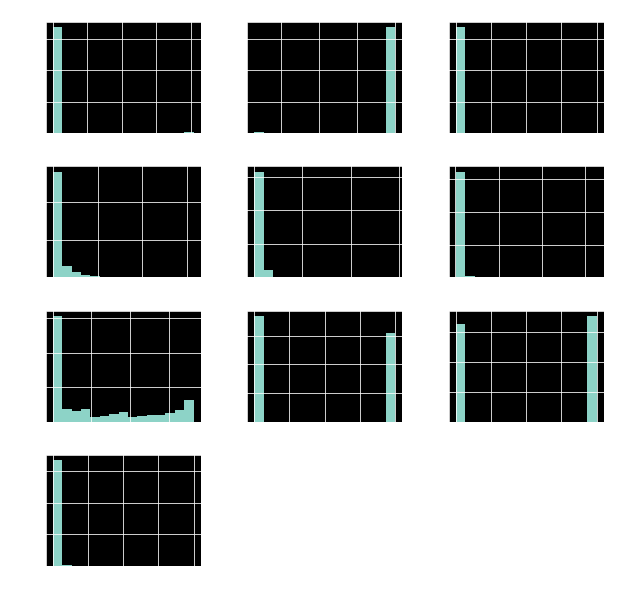

In [9]:
train2_hist = train2.hist(bins=15, figsize=(10,10))

remove latitude and longitude out of range


In [10]:
#train2 = train2[(train2['latitude'] >= -90) & (train2['latitude'] <= 90)]
#train2 = train2[(train2['longitude'] >= -180) & (train2['longitude'] <= 80)]

remove outliers

In [11]:
#train2 = train2[train2.minimum_nights != 1000.000000]
#train2 = train2[train2.minimum_nights != 999.000000]
#train2 = train2[train2.minimum_nights != 500.000000]
#train2 = train2[train2.minimum_nights != 370.000000]
#train2 = train2[train2.price != 10000]
#train2 = train2[train2.price != 9999]

check correlations

In [13]:
corr = train2.corr()
corr.style.background_gradient(cmap='coolwarm')

,latitude,longitude,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365,Private_room,Entire_home/apt,price
latitude,1.000000,-0.000775,0.001759,0.000225,0.006321,0.006180,-0.003713,-0.000699,0.003241,-0.003101
longitude,-0.000775,1.000000,-0.007274,0.005698,0.011825,-0.001690,0.004808,-0.004886,0.003301,0.003884
minimum_nights,0.001759,-0.007274,1.000000,-0.082849,-0.129051,0.132921,0.148433,-0.074589,0.073630,0.042982
number_of_reviews,0.000225,0.005698,-0.082849,1.000000,0.585578,-0.072459,0.178875,0.015274,-0.009056,-0.047864
reviews_per_month,0.006321,0.011825,-0.129051,0.585578,1.000000,-0.049871,0.166600,0.025742,-0.025903,-0.048883
calculated_host_listings_count,0.006180,-0.001690,0.132921,-0.072459,-0.049871,1.000000,0.224036,-0.110756,0.113787,0.054862
availability_365,-0.003713,0.004808,0.148433,0.178875,0.166600,0.224036,1.000000,-0.016487,-0.000934,0.078617
Private_room,-0.000699,-0.004886,-0.074589,0.015274,0.025742,-0.110756,-0.016487,1.000000,-0.953344,-0.229030
Entire_home/apt,0.003241,0.003301,0.073630,-0.009056,-0.025903,0.113787,-0.000934,-0.953344,1.000000,0.244510
price,-0.003101,0.003884,0.042982,-0.047864,-0.048883,0.054862,0.078617,-0.229030,0.244510,1.000000


remove outliers

In [12]:
cols = ['minimum_nights', 'price']
q1 = train2[cols].quantile(.10)
q3 = train2[cols].quantile(.90)
iqr = q3 - q1

In [14]:
train2 = train2[~((train2 < (q1 - 1.5 * iqr)) | (train2 > (q3 + 1.5 * iqr))).any(axis=1)]
train2.describe()

,latitude,longitude,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365,Private_room,Entire_home/apt,price
count,33105.000000,33105.000000,33105.000000,33105.000000,33105.000000,33105.000000,33105.000000,33105.000000,33105.000000,33105.000000
mean,397.134158,-770.243227,5.911524,23.712007,1.110852,7.023833,111.070140,0.462226,0.513820,133.999668
std,3791.301734,7138.565682,8.929690,44.920455,1.620840,32.579430,130.801027,0.498579,0.499817,94.007105
min,40.499790,-74142.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,40.690180,-73.983180,1.000000,1.000000,0.040000,1.000000,0.000000,0.000000,0.000000,69.000000
50%,40.723230,-73.955610,2.000000,5.000000,0.380000,1.000000,42.000000,0.000000,1.000000,104.000000
75%,40.764020,-73.936430,5.000000,24.000000,1.630000,2.000000,220.000000,1.000000,1.000000,175.000000
max,40894.000000,-73.712990,68.000000,629.000000,58.500000,327.000000,365.000000,1.000000,1.000000,600.000000


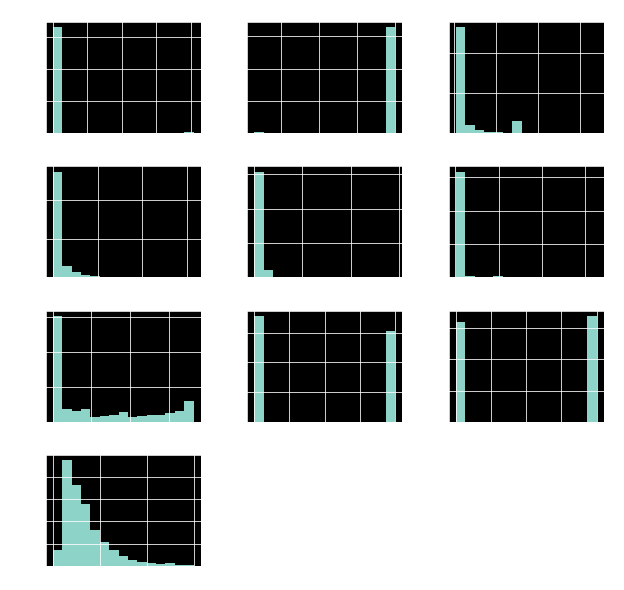

In [15]:
train2_hist = train2.hist(bins=15, figsize=(10,10))

check duplicates

In [16]:
print('Train duplicated:', train2.duplicated().sum())

Train duplicated: 0


remove duplicates

In [17]:
#train2.drop_duplicates(keep = False, inplace = True) 
#print('Train duplicated:', train2.duplicated().sum())

check NaN

In [18]:
train2.isnull().sum()

latitude                          0
longitude                         0
minimum_nights                    0
number_of_reviews                 0
reviews_per_month                 0
calculated_host_listings_count    0
availability_365                  0
Private_room                      0
Entire_home/apt                   0
price                             0
dtype: int64

check types

In [19]:
train2.dtypes

latitude                          float64
longitude                         float64
minimum_nights                      int64
number_of_reviews                   int64
reviews_per_month                 float64
calculated_host_listings_count      int64
availability_365                    int64
Private_room                        int64
Entire_home/apt                     int64
price                               int64
dtype: object

shuffle rows

In [20]:
train2 = train2.sample(frac=1).reset_index(drop=True)

scaler

In [21]:
column_names_to_normalize = ['latitude', 'longitude', 'minimum_nights', 'number_of_reviews', 'calculated_host_listings_count', 'availability_365']
x = train2[column_names_to_normalize].values
scaler = MinMaxScaler() 
x_scaled = scaler.fit_transform(x) 
df_temp = pd.DataFrame(x_scaled, columns=column_names_to_normalize, index = train2.index)
train2[column_names_to_normalize] = df_temp
train2

,latitude,longitude,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365,Private_room,Entire_home/apt,price
0,0.000009,0.999997,0.029851,0.007949,1.95,0.000000,0.054795,1,0,60
1,0.000006,0.999997,0.000000,0.019078,0.97,0.000000,0.000000,1,0,85
2,0.000003,0.999994,0.000000,0.009539,2.20,0.000000,0.865753,0,1,85
3,0.000006,0.999996,0.432836,0.020668,0.24,0.116564,0.797260,0,1,300
4,0.000003,0.999997,0.029851,0.006359,0.18,0.000000,0.000000,0,1,95
...,...,...,...,...,...,...,...,...,...,...
33100,0.000007,0.999997,0.194030,0.000000,0.00,0.000000,0.000000,1,0,75
33101,0.000004,0.999996,0.029851,0.007949,0.12,0.000000,0.060274,0,1,350
33102,0.000004,0.999998,0.014925,0.058824,1.21,0.009202,0.432877,1,0,45
33103,0.000006,0.999997,0.432836,0.036566,0.68,0.000000,0.367123,0,1,235


### y_train

In [22]:
train_label = train2['price'].to_frame()
train_label 

,price
0,60
1,85
2,85
3,300
4,95
...,...
33100,75
33101,350
33102,45
33103,235


In [23]:
print('Price mean:', train_label.mean())

Price mean: price    133.999668
dtype: float64


In [24]:
print('Price std:', train_label.std())

Price std: price    94.007105
dtype: float64


### X_train

In [25]:
train2.drop(['price'], axis=1, inplace=True)
train2

,latitude,longitude,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365,Private_room,Entire_home/apt
0,0.000009,0.999997,0.029851,0.007949,1.95,0.000000,0.054795,1,0
1,0.000006,0.999997,0.000000,0.019078,0.97,0.000000,0.000000,1,0
2,0.000003,0.999994,0.000000,0.009539,2.20,0.000000,0.865753,0,1
3,0.000006,0.999996,0.432836,0.020668,0.24,0.116564,0.797260,0,1
4,0.000003,0.999997,0.029851,0.006359,0.18,0.000000,0.000000,0,1
...,...,...,...,...,...,...,...,...,...
33100,0.000007,0.999997,0.194030,0.000000,0.00,0.000000,0.000000,1,0
33101,0.000004,0.999996,0.029851,0.007949,0.12,0.000000,0.060274,0,1
33102,0.000004,0.999998,0.014925,0.058824,1.21,0.009202,0.432877,1,0
33103,0.000006,0.999997,0.432836,0.036566,0.68,0.000000,0.367123,0,1


## Train & Validation

In [26]:
X_train, X_validation, y_train, y_validation = train_test_split(train2, train_label, test_size=0.15, random_state=0)
print('X_train dimensions:', X_train.shape)
print('Y_train dimensions:', y_train.shape)
print('X_validation dimensions:', X_validation.shape)
print('Y_validation dimensions:', y_validation.shape)

X_train dimensions: (28139, 9)
Y_train dimensions: (28139, 1)
X_validation dimensions: (4966, 9)
Y_validation dimensions: (4966, 1)


## Model

### LRFinder

### configuration and train

In [27]:
from keras_lr_finder import LRFinder
from tensorflow.keras.optimizers import SGD, Adam

In [28]:
# Model configuration
activation = 'relu'
batch_size = 32
epochs = 15
dims = y_train.shape[1]
start_lr = 10e-5
end_lr = 1
moving_average = 20

In [29]:
# Determine tests you want to perform
tests = [
  (SGD(), 'SGD'),
  (Adam(), 'Adam'),
]

In [30]:
# Set containers for tests
test_learning_rates = []
test_losses = []
test_loss_changes = []
labels = []

In [31]:
def NeuralNetwork(X, n_outputs, activation):
    inputs = Input(shape = (X.shape[1])) 
    x = layers.Dense(16, activation = activation) (inputs)
    x = layers.Dense(8, activation = activation) (x)
    x = layers.Dense(n_outputs) (x) 
    model = Model(inputs, x)
    #model.compile(loss = 'mse', optimizer=optimizer, metrics = [tf.keras.metrics.RootMeanSquaredError(), tf.keras.metrics.MeanAbsoluteError()]) 
    return model

In [32]:
# Perform each test
for test_optimizer, label in tests:

  # Compile the model
  model = NeuralNetwork(X=X_train, n_outputs=dims, activation=activation)
  model.compile(loss = 'mae', optimizer=test_optimizer, metrics = [tf.keras.metrics.RootMeanSquaredError()]) 

  # Instantiate the Learning Rate Range Test / LR Finder
  lr_finder = LRFinder(model)

  # Perform the Learning Rate Range Test
  outputs = lr_finder.find(X_train, y_train, start_lr=start_lr, end_lr=end_lr, batch_size=batch_size, epochs=epochs)
  #lr_finder.plot_loss(n_skip_beginning=20, n_skip_end=5)


  # Get values
  learning_rates  = lr_finder.lrs
  losses          = lr_finder.losses
  loss_changes = []

  # Compute smoothed loss changes
  # Inspired by Keras LR Finder: https://github.com/surmenok/keras_lr_finder/blob/master/keras_lr_finder/lr_finder.py
  for i in range(moving_average, len(learning_rates)):
    loss_changes.append((losses[i] - losses[i - moving_average]) / moving_average)

  # Append values to container
  test_learning_rates.append(learning_rates)
  test_losses.append(losses)
  test_loss_changes.append(loss_changes)
  labels.append(label)

  K.clear_session()
  del model


Epoch 1/15
880/880 [==============================] - 2s 2ms/step - loss: 133.6887 - root_mean_squared_error: 163.6246
Epoch 2/15
880/880 [==============================] - 2s 3ms/step - loss: 131.0566 - root_mean_squared_error: 161.4314
Epoch 3/15
880/880 [==============================] - 2s 3ms/step - loss: 89.2869 - root_mean_squared_error: 126.3167
Epoch 4/15
880/880 [==============================] - 2s 3ms/step - loss: 52.3497 - root_mean_squared_error: 84.0472
Epoch 5/15
880/880 [==============================] - 2s 2ms/step - loss: 50.6848 - root_mean_squared_error: 81.5570
Epoch 6/15
880/880 [==============================] - 2s 2ms/step - loss: 50.4405 - root_mean_squared_error: 81.2220
Epoch 7/15
880/880 [==============================] - 2s 3ms/step - loss: 50.1776 - root_mean_squared_error: 80.8843
Epoch 8/15
880/880 [==============================] - 2s 2ms/step - loss: 50.0338 - root_mean_squared_error: 80.5260
Epoch 9/15
880/880 [==============================] - 2s 2m

### plot for Loss Deltas and Values

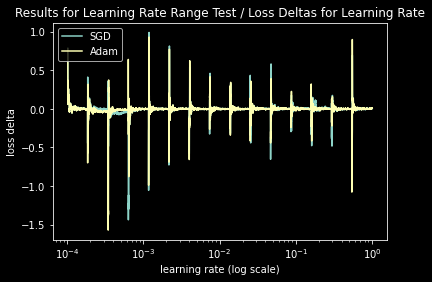

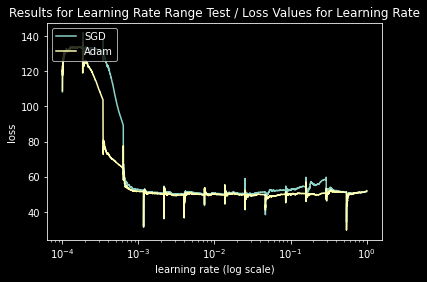

In [33]:
# Generate plot for Loss Deltas
for i in range(0, len(test_learning_rates)):
  plt.style.use('dark_background')
  plt.plot(test_learning_rates[i][moving_average:], test_loss_changes[i], label=labels[i])
plt.xscale('log')
plt.legend(loc='upper left')
plt.ylabel('loss delta')
plt.xlabel('learning rate (log scale)')
plt.title('Results for Learning Rate Range Test / Loss Deltas for Learning Rate')
plt.show()

# Generate plot for Loss Values
for i in range(0, len(test_learning_rates)):
  plt.style.use('dark_background')
  plt.plot(test_learning_rates[i], test_losses[i], label=labels[i])
plt.xscale('log')
plt.legend(loc='upper left')
plt.ylabel('loss')
plt.xlabel('learning rate (log scale)')
plt.title('Results for Learning Rate Range Test / Loss Values for Learning Rate')
plt.show()

### Activation Function

### configuration and train


alpha parameter of the Leaky-Relu function

In [34]:
get_custom_objects().update({'leaky-relu': Activation(LeakyReLU(alpha=0.01))})

GELU function

In [35]:
def gelu(x):
    return 0.5 * x * (1 + tf.tanh(tf.sqrt(2 / np.pi) * (x + 0.044715 * tf.pow(x, 3))))
get_custom_objects().update({'gelu': Activation(gelu)})

Swish function

In [36]:
def swish(x, beta = 1):
    return (x * sigmoid(beta * x))
get_custom_objects().update({'swish': Activation(swish)})

activation functions

In [37]:
#act_func = ['relu']
act_func = ['relu', 'leaky-relu', 'elu', 'gelu', 'selu', 'swish']

training model

In [38]:
result = []
for activation in act_func:
    print('\nTraining with -->{0}<-- activation function\n'.format(activation))
    model = NeuralNetwork(X = X_train, activation=activation, n_outputs=dims)
    model.compile(loss = 'mae', optimizer=Adam(lr=10e-3), metrics = [tf.keras.metrics.RootMeanSquaredError()]) 
    
    history = model.fit(X_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=0,
          validation_data=(X_validation, y_validation))
    
    result.append(history)
    
    K.clear_session()
    del model


Training with -->relu<-- activation function


Training with -->leaky-relu<-- activation function


Training with -->elu<-- activation function


Training with -->gelu<-- activation function


Training with -->selu<-- activation function


Training with -->swish<-- activation function



### plot of validation rmse

<Figure size 720x504 with 0 Axes>

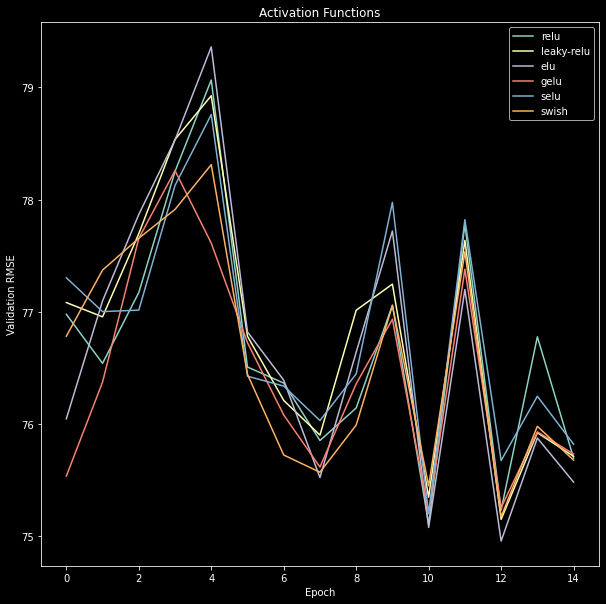

In [39]:
rmse_finale = []

def plot_act_func_results(results, activation_functions = []):
    plt.figure(figsize=(10,7))
    plt.style.use('dark_background')
    
    # Plot of the validation root mean squared error
    plt.figure(figsize=(10,10))
    
    for act_func in results:
        plt.plot(act_func.history['val_root_mean_squared_error'])
        rmse_finale.append(act_func.history['val_root_mean_squared_error'][-1])
    
    plt.title('Activation Functions')
    plt.ylabel('Validation RMSE')
    plt.xlabel('Epoch')
    plt.legend(activation_functions)
    plt.show()

plot_act_func_results(result, act_func)

final model

In [40]:
activation = 'gelu'
model = NeuralNetwork(X = X_train, activation=activation, n_outputs=dims)
model.compile(loss = 'mae', optimizer=Adam(lr=10e-3), metrics = [tf.keras.metrics.RootMeanSquaredError()]) 
model.summary()
model.fit(X_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1)

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 9)]               0         
_________________________________________________________________
dense (Dense)                (None, 16)                160       
_________________________________________________________________
dense_1 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 9         
Total params: 305
Trainable params: 305
Non-trainable params: 0
_________________________________________________________________
Epoch 1/15
880/880 [==============================] - 2s 2ms/step - loss: 54.7825 - root_mean_squared_error: 86.9232
Epoch 2/15
880/880 [==============================] - 2s 2ms/step - loss: 49.7125 - root_mean_squared_error: 80.1871
Epoch 3/15
880/880 [

### Testing

X_test

In [41]:
test.drop(['Unnamed: 0'], axis=1, inplace=True)
test.describe()

,latitude,longitude,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365,Private_room,Entire_home/apt
count,3765.000000,3765.000000,3765.000000,3765.000000,3765.000000,3765.000000,3765.000000,3765.000000,3765.000000
mean,397.429772,-623.385344,7.717663,22.546348,1.073421,8.124568,115.432669,0.451262,0.526959
std,3793.819578,6348.269973,31.688428,42.644924,1.553516,37.043267,132.790393,0.497685,0.499339
min,40.507080,-74124.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000
25%,40.689430,-73.984260,1.000000,1.000000,0.040000,1.000000,0.000000,0.000000,0.000000
50%,40.723370,-73.956270,2.000000,5.000000,0.380000,1.000000,51.000000,0.000000,1.000000
75%,40.763420,-73.935150,5.000000,24.000000,1.550000,2.000000,231.000000,1.000000,1.000000
max,40833.000000,-73.724350,1250.000000,447.000000,20.940000,327.000000,365.000000,1.000000,1.000000


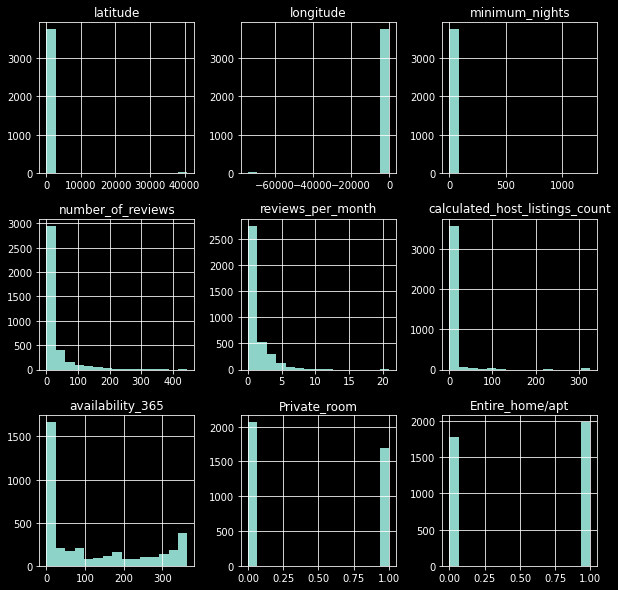

In [42]:
test_hist = test.hist(bins=15, figsize=(10,10))

In [43]:
x = test[column_names_to_normalize].values
x_scaled = scaler.fit_transform(x) 
df_temp = pd.DataFrame(x_scaled, columns=column_names_to_normalize, index = test.index)
test[column_names_to_normalize] = df_temp
test

,latitude,longitude,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365,Private_room,Entire_home/apt
0,0.000004,0.999997,0.000801,0.008949,0.17,0.000000,0.000000,0,1
1,0.000004,0.999997,0.000000,0.020134,0.61,0.000000,0.000000,1,0
2,0.000004,0.999997,0.000801,0.069351,1.35,0.012270,0.000000,1,0
3,0.000004,0.999998,0.001601,0.000000,0.00,0.003067,0.994521,1,0
4,0.000004,0.999997,0.000000,0.015660,0.19,0.000000,0.000000,1,0
...,...,...,...,...,...,...,...,...,...
3760,0.000002,0.999997,0.000801,0.163311,2.15,0.000000,0.904110,0,1
3761,0.000008,0.999997,0.000000,0.008949,0.85,0.003067,1.000000,1,0
3762,0.000004,0.999997,0.000000,0.008949,0.30,0.000000,0.000000,0,1
3763,0.000007,0.999997,0.000801,0.004474,0.03,0.000000,0.000000,0,1


predict y_test

In [44]:
y_test_round = np.round(model.predict(test))
y_test_round

array([[150.],
       [ 72.],
       [ 68.],
       ...,
       [151.],
       [161.],
       [ 75.]], dtype=float32)

In [45]:
y_test = model.predict(test)
y_test

array([[149.86264 ],
       [ 72.414154],
       [ 68.201164],
       ...,
       [151.47427 ],
       [160.61423 ],
       [ 75.25267 ]], dtype=float32)

In [46]:
print('Predictions mean:', y_test.mean())

Predictions mean: 126.14323


In [47]:
print('Predictions std:', y_test.std())

Predictions std: 56.023148


In [48]:
K.clear_session()
del model

save y_test for assignment

In [49]:
np.savetxt('y_test_round.txt', y_test_round, delimiter='\n', fmt='%d') 
np.savetxt('y_test.txt', y_test, delimiter='\n', fmt='%f') 